In [19]:
import pandas as pd
import matplotlib

# Loading

In [21]:
infile = "data/sp500.csv"
df = pd.read_csv(infile, index_col='Date')

# Exploration

In [22]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,0,0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,0,0
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,0,0


<AxesSubplot: xlabel='Date'>

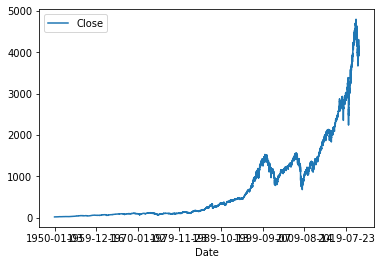

In [23]:
df.plot.line(y='Close', use_index=True)

# Cleaning

In [24]:
del df['Dividends']
del df['Stock Splits']

In [25]:
df['Tomorrow'] = df['Close'].shift(-1)
df.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.850000
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.930000
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.980000
1950-01-06,16.98,16.98,16.98,16.98,2010000,17.080000
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.030001


In [26]:
df['Target'] = (df['Tomorrow'] > df['Close']).astype(int)
df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.850000,1
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.930000,1
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.980000,1
1950-01-06,16.98,16.98,16.98,16.98,2010000,17.080000,1
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.030001,0


In [27]:
# Remove all data older than 1990-01-01
df = df.loc["1990-01-01":].copy()
df

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,4006.179932,1
2022-09-08,3959.939941,4010.500000,3944.810059,4006.179932,0,4067.360107,1


# Model Development

## Training

In [28]:
# Initialize model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [29]:
# Training model
training_data = df.iloc[:-100]
test_data = df.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(training_data[predictors], training_data['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

## Prediction

In [30]:
predictions = model.predict(df[predictors])

predictions = pd.Series(predictions, index=df.index)

predictions

Date
1990-01-02    0
1990-01-03    0
1990-01-04    0
1990-01-05    1
1990-01-08    1
             ..
2022-09-06    1
2022-09-07    0
2022-09-08    1
2022-09-09    1
2022-09-12    1
Length: 8238, dtype: int64

## Measurements

In [31]:
from sklearn.metrics import precision_score

precision_score(df["Target"], predictions)

0.7056569343065694

<AxesSubplot: xlabel='Date'>

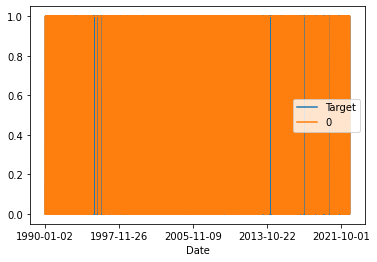

In [32]:
combined = pd.concat([df['Target'], predictions], axis=1)
combined.plot()

In [33]:
# # Building a Backtester
def predict(training_data, data, predictors, model):
    model.fit(training_data[predictors], training_data['Target'])
    predictions = model.predict(data[predictors])
    predictions = pd.Series(predictions, index=data.index, name='Predictions')
    return pd.concat([data['Target'], predictions], axis=1)

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        training_data = data.iloc[0:i].copy()
        test_data = data.iloc[i:(i+step)].copy()
        predictions = predict(training_data, test_data, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [35]:
predictions = backtest(df, model, predictors)

In [36]:
predictions['Predictions'].value_counts()

0    3337
1    2401
Name: Predictions, dtype: int64

In [37]:
precision_score(predictions['Target'], predictions['Predictions'])

0.534777176176593

In [38]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.536075
0    0.463925
Name: Target, dtype: float64

In [39]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df['Close'] / rolling_averages['Close']
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

In [41]:
df = df.dropna()

In [42]:
df

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-02,3994.659912,4018.429932,3906.209961,3924.260010,4134920000,3908.189941,0,0.994603,1.0,0.987838,1.0,0.985722,26.0,0.905996,120.0,1.108446,543.0
2022-09-06,3930.889893,3942.550049,3886.750000,3908.189941,2209800080,3979.870117,1,0.997948,0.0,0.989893,1.0,0.982136,26.0,0.902791,120.0,1.103594,542.0
2022-09-07,3909.429932,3987.889893,3906.030029,3979.870117,0,4006.179932,1,1.009087,1.0,1.008370,2.0,0.999819,27.0,0.919786,121.0,1.123489,543.0


# Improving Model

In [44]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [45]:
# # Building a Backtester
def predict(training_data, data, predictors, model):
    model.fit(training_data[predictors], training_data['Target'])
    predictions = model.predict_proba(data[predictors])[:,1]
    predictions[predictions >= 0.6] = 1
    predictions[predictions < 0.6] = 0
    predictions = pd.Series(predictions, index=data.index, name='Predictions')
    return pd.concat([data['Target'], predictions], axis=1)

In [46]:
predictions = backtest(df, model, new_predictors)

In [47]:
predictions['Predictions'].value_counts()

0.0    3932
1.0     805
Name: Predictions, dtype: int64

In [48]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5701863354037268

In [49]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.546971
0    0.453029
Name: Target, dtype: float64